# NodeConstructor Demo

This notebook is intended to show the functionality of the NodeConstructor. The custom structure is used to generate the ODE system of a energy grid. The grid can ether be externally specified or randomly generated. The goal is then to create the grid given the parameters of the objects within and generate the ODEs, which will then be output in the state space representation and can be solved using `lsim()` within the ControlSystems ([Source](https://juliacontrol.github.io/ControlSystems.jl/latest/man/creating_systems/#ss-Creating-State-Space-Systems)).

In [1]:
using DrWatson
@quickactivate "MicroGridSimWithRL"

using ControlSystems
using JSON
using Plots
using LinearAlgebra


include(srcdir("nodeconstructor.jl"));

## Step by step guide for the construction of a simple grid

In this example, the goal is to build a simple node. The individual parameters of the NodeConstructor function are explained in detail in order to get a good intuition for the underlying functionalities.

### Connection Matrix

One of the core elements of the NodeConstructor is the Connection Matrix (CM). It specifies how the elements of the node are connected. Possible elements that can appear in such a network are on the one hand sources, on the other hand loads. If we want to create a node with two sources and one load, the corresponding CM matrix could looks like this:

In [2]:
CM = [ 0  0  1
       0  0  2
      -1 -2  0];

An entry in the CM reads as follows: Element x (row) is connected to element y (column) via connection line z.

x ---z---> y

The rows and columns are arranged in such a way that first only sources and then only loads are noted. For this example we need 2 sources and 1 load, so the following is a CM of size 3x3. The connection from the first source to the load is then marked by the entry "1" in `CM[1,3]`. We can read this as: The first source is connected to the load via cable one. For the second source the same applies with the entry "2" in `CM[2,3]`. Since a source and neither a load cannot be connected to itself, there are zeros on the main diagonal.

The matrix is always antisymmetrical, therefore the same entries are found on the opposing diagonal, but with a negative sign. We can interpret the signs as assumed current direction.

## Parameter Dict

Next, we want to set the parameters of our elements.

The sources differ in the various filter types. Currently, one can decide between L, LC and LCL filters. We use two LCL filters. The parameters of a source are then stored in a dict:

In [3]:
source = Dict()
source["fltr"] = "LCL"
source["R1"] = 0.4
source["R2"] = 0.4
source["R_C"] = 0.4
source["L1"] = 2.3e-3
source["L2"] = 2.3e-3
source["C"] = 10e-6;

We get a separate dict for each source, which are then stored in a list.

In [4]:
source_list = []
push!(source_list, source, source);

In [5]:
source_list

2-element Vector{Any}:
 Dict{Any, Any}("L1" => 0.0023, "R_C" => 0.4, "L2" => 0.0023, "C" => 1.0e-5, "R1" => 0.4, "fltr" => "LCL", "R2" => 0.4)
 Dict{Any, Any}("L1" => 0.0023, "R_C" => 0.4, "L2" => 0.0023, "C" => 1.0e-5, "R1" => 0.4, "fltr" => "LCL", "R2" => 0.4)

Also for the load a dict must be created in which the parameters are defined. Currently, resistive, inductive and capacitive loads as well as all combinations of these types can be created. The loads are then also gathered in a list.

In [6]:
load = Dict()
load["impedance"] = "R"
load["R"] = 14;

load_list = []
push!(load_list, load);

And the same also for the cables in the network.

In [7]:
cable_list = []

cable = Dict()
cable["R"] = 0.4
cable["L"] = 2.3e-3
cable["C"] = 1e-20;

push!(cable_list, cable, cable);

The individual lists are then collected again in a parameter dict.

In [8]:
parameters = Dict()

parameters["source"] = source_list
parameters["cable"] = cable_list
parameters["load"] = load_list;

## The NodeConstructor

Now a network defined by us can be created. Important here: The number of sources and loads must be passed as parameters.

In [9]:
S2_L1 = NodeConstructor(num_source=2, num_loads=1, CM=CM, parameters=parameters);

With the function `draw_graph()` the topology of the grid can now be displayed. Here, the color x corresponds to a y and the color z corresponds to a w.

In [10]:
draw_graph(S2_L1) #TODO

"Plots a graph according to the CM matrix\n\nRed nodes corresponse to a source.\nLightblue nodes corresponse to a load.\n"

After the grid has been created it can be passed to the function `get_sys()`, which then returns the matrices for the state space representation in the continous time domain.

In [11]:
A, B, C, D = get_sys(S2_L1);

We convert the matrices into the discrete time domain and create a discrete StateSpace object with the help of `ControlSystems`. This object can then represent the dynamics of the system for a given time interval using the function `lsim()`.

In [12]:
ts = 1e-5
Ad = exp(A*ts)
Bd = A \ (Ad - C) * B
sys_d = StateSpace(Ad, Bd, C, D, ts);

To use `lsim()`you need defined initial states `x0`, a time vector `t` and a input signal `u`. In our case we apply a jump to 250 V to the system.

In [13]:
ns = length(A[1,:]) # get num of states
ni = length(B[1,:]) # get num of inputs
t = collect(0:ts:0.1)
x0 = [0.0 for i = 1:ns]
u = [250.0 for i = 1:length(t)]
uu = [u for i = 1:ni ]
uuu = mapreduce(permutedims, vcat, uu);

`lsim()` now solves the difference equations for the given time steps and we can observe how the states vary.

In [14]:
xout, _, _, _ = lsim(sys_d,uuu,t,x0=x0);

Here we plot the voltage across the capacitor in the first source.

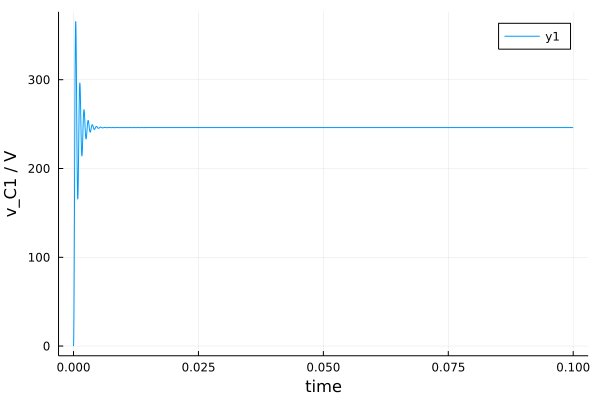

In [15]:
p = plot!(t, xout[2,:], xlabel="time", ylabel="v_C1 / V")
display(plot(p))

## Automatic generation of the grids

An important feature is the creation of random node structures, where the parameters of the elements are chosen randomly. For fully connected structures, this can be generated, for example, using the parameters `S2S_p` and `S2L_p`. These indicate the connection probability of a source with any other source or with a load. If these parameters are set to 1, a fully connected node is generated.

In [ ]:
S2_L2_FC = NodeConstructor(num_source=2, num_loads=2, S2S_p=1, S2L_p=1);

Let's check the CM matrix.

In [ ]:
S2_L2_FC.CM

With a look into the parameter dict we also see that the parameters of the individual elements were randomly generated. The current policy for the sources is that an LC filter is always taken and the other filter types are chosen randomly.

In [ ]:
S2_L2_FC.parameters["source"]

For larger networks, of course, only the number of sources and loads can be handed over, so that the network structures are created on the basis of the default values. An important point here is that it is ensured that no subnets are created. By default, it is ensured that each element of the network has at least one connection to the other components of the network, so that no subnetworks are created.

In [ ]:
S5_L15 = NodeConstructor(num_source=5, num_loads=15);